<a href="https://colab.research.google.com/github/lilfetz22/Health_Scores_CAP2/blob/master/Health_Scores_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Scores Machine Learning

How healthy is your city? This notebook goes through the process of determining how your city ranks among the top 500 cities in the United States. The data that is brought in this notebook were manipulated in Health_scores_EDA jupyter notebook. The data did not come with any labels for classification; thus, this notebook uses several classification methods to then complete the classification models. This notebook begins by using the following clusterization techniques: 


1.   KMeans
3.   Optics
4.   Hierarchical Clustering
5.   HBDSCAN
6.   Affinity Propagation

Next the data was classified using classification models predicting the clusters. The following models were used during classification:



1.   Logistic Regression
2.   Decision Tree
3.   Random Forest
4.   LightGBM
5.   XGBoost


The models were then compared with each classification method and clusterization labels. The best combination appeared to be using ________ classification and __________ clustering. 

Finally, each location was given a rank for each feature. The feature importances found from the classification model were used to weight the features producing a score for each feature in each location. The location was scored based upon all features and given an **Overall Health Score** 







In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns
import warnings
import io
import lightgbm as lgb
import xgboost as xgb
import re
import hdbscan
from random import seed, randint,sample
from sklearn.cluster import OPTICS,KMeans,AgglomerativeClustering,AffinityPropagation
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive

In [11]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
city_data_scaled = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/city_data_scaled.csv",
                               index_col='stpl_fips')
tract_data_scaled = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/tract_data_scaled.csv",
                               index_col='stcotr_fips')
city_data_manip = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/city_data_manip.csv",
                               index_col='stpl_fips')
tract_data_manip = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/tract_data_manip.csv",
                               index_col='stcotr_fips')
leri_city = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/leri_city.csv",
                               index_col='stpl_fips')
leri_tract = pd.read_csv("/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/leri_tract.csv",
                               index_col='stcotr_fips')

## Clustering

### KMeans

100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


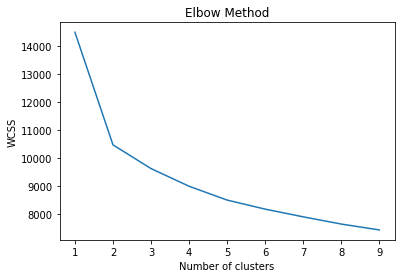

In [13]:
# Elbow Method
wcss = []
for i in tqdm(range(1, 10)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(city_data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [0]:
def silhouette_analysis_fx(df):
  ''' this creates a silhouette analysis for KMeans. This function was borrowed 
  from https://imaddabbura.github.io/post/kmeans-clustering/. 

  args: 
      df - dataframe to use in KMeans classification
  '''
  for i, k in enumerate([2, 3, 4, 5, 6]):
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)
      
      # Run the Kmeans algorithm
      km = KMeans(n_clusters=k)
      labels_cluster = km.fit_predict(df)
      centroids = km.cluster_centers_

      # Get silhouette samples
      silhouette_vals = silhouette_samples(df, labels_cluster)
  
      # Silhouette plot
      y_ticks = []
      y_lower, y_upper = 0, 0
      for i, cluster in enumerate(np.unique(labels_cluster)):
          cluster_silhouette_vals = silhouette_vals[labels_cluster == cluster]
          cluster_silhouette_vals.sort()
          y_upper += len(cluster_silhouette_vals)
          ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
          ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
          y_lower += len(cluster_silhouette_vals)

      # Get the average silhouette score and plot it
      avg_score = np.mean(silhouette_vals)
      print(avg_score)
      ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
      ax1.set_yticks([])
      ax1.set_xlim([-0.1, 0.5])
      ax1.set_xlabel('Silhouette coefficient values')
      ax1.set_ylabel('Cluster labels')
      ax1.set_title('Silhouette plot for the various clusters', y=1.02);
      
      # Scatter plot of data colored with labels
      ax2.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels_cluster)
      ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
      ax2.set_xlim([-2, 2])
      ax2.set_xlim([-2, 2])
      ax2.set_xlabel('Eruption time in mins')
      ax2.set_ylabel('Waiting time to next eruption')
      ax2.set_title('Visualization of clustered data', y=1.02)
      ax2.set_aspect('equal')
      plt.tight_layout()
      plt.suptitle(f'Silhouette analysis using k = {k}',
                  fontsize=16, fontweight='semibold', y=1.05);

0.2308296842263309
0.13128922150922984
0.11909266693324976
0.12259859423807982
0.11503630180886047


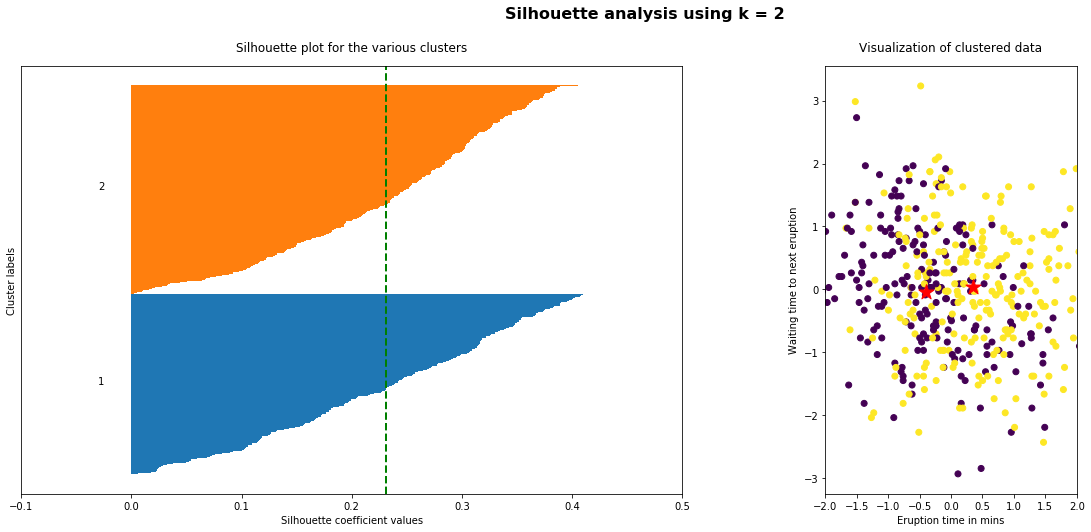

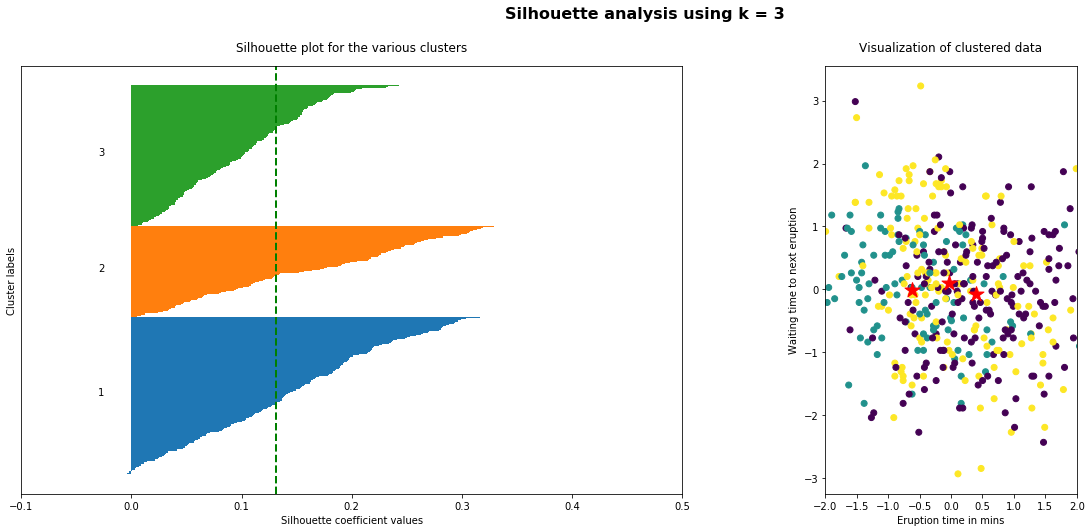

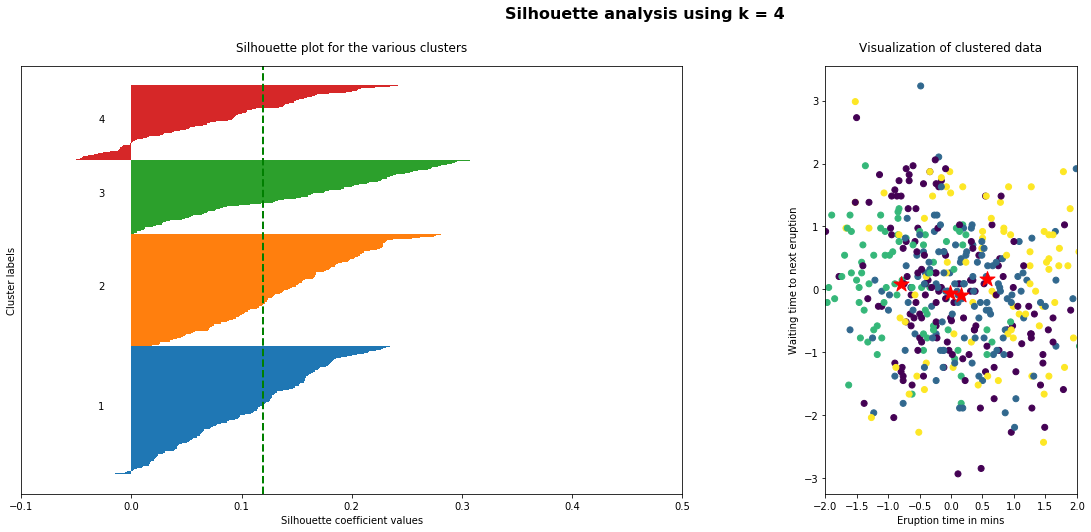

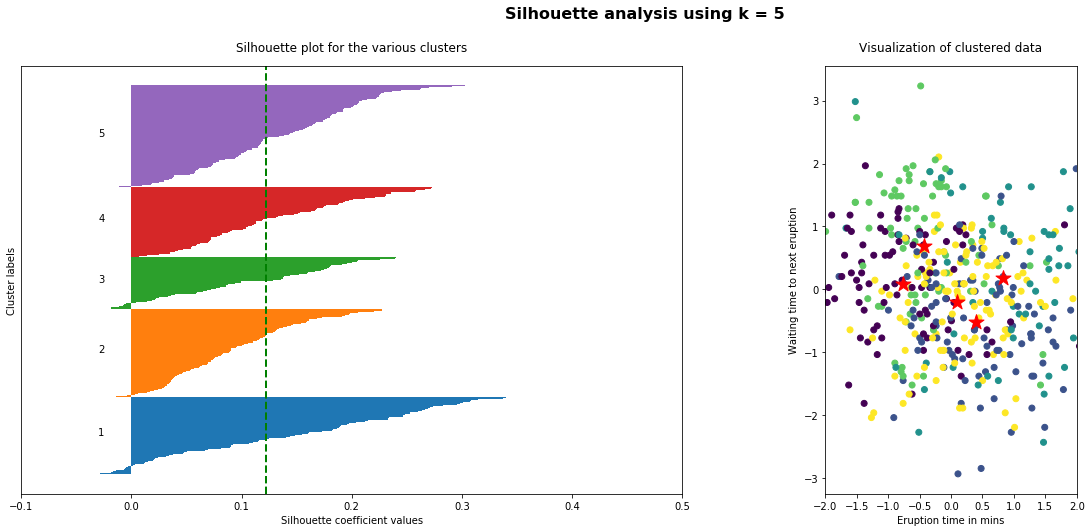

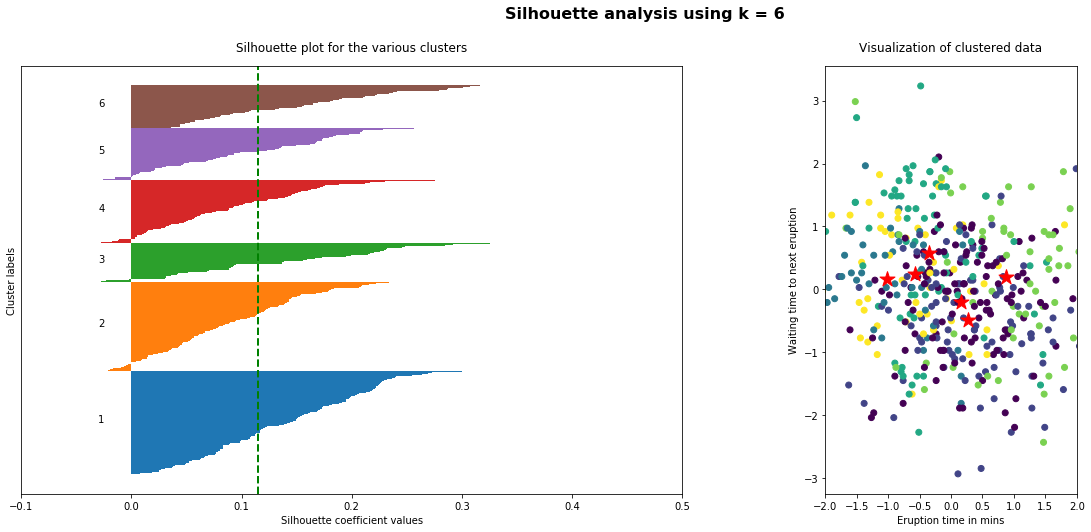

In [15]:
silhouette_analysis_fx(city_data_scaled)

0.2139885450148926
0.22869582334403243
0.23510475910475487
0.18718207131119757
0.17744682754134075


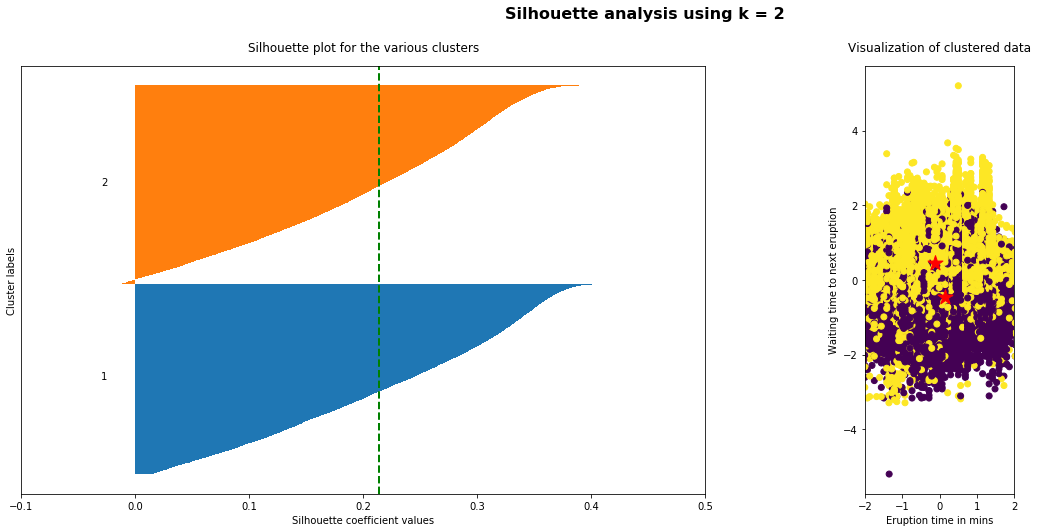

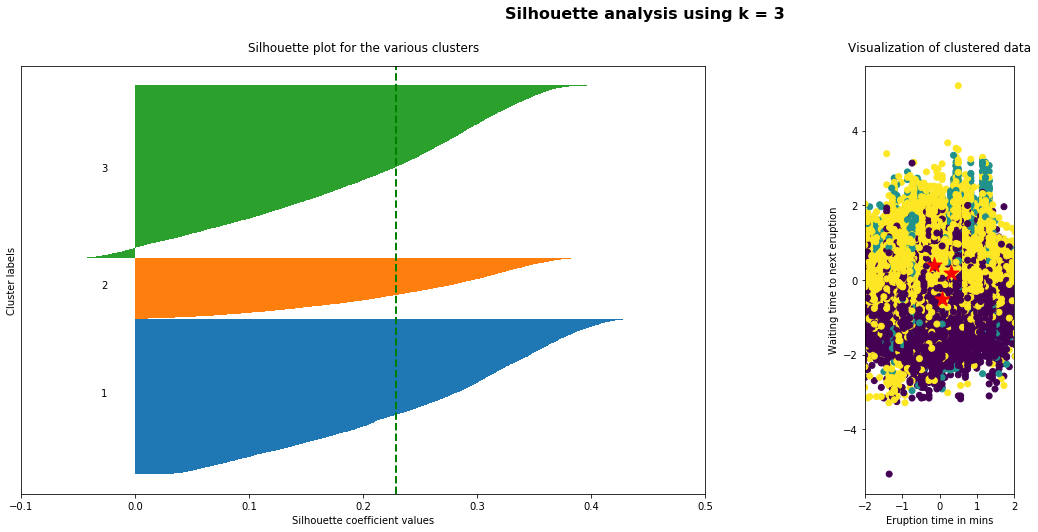

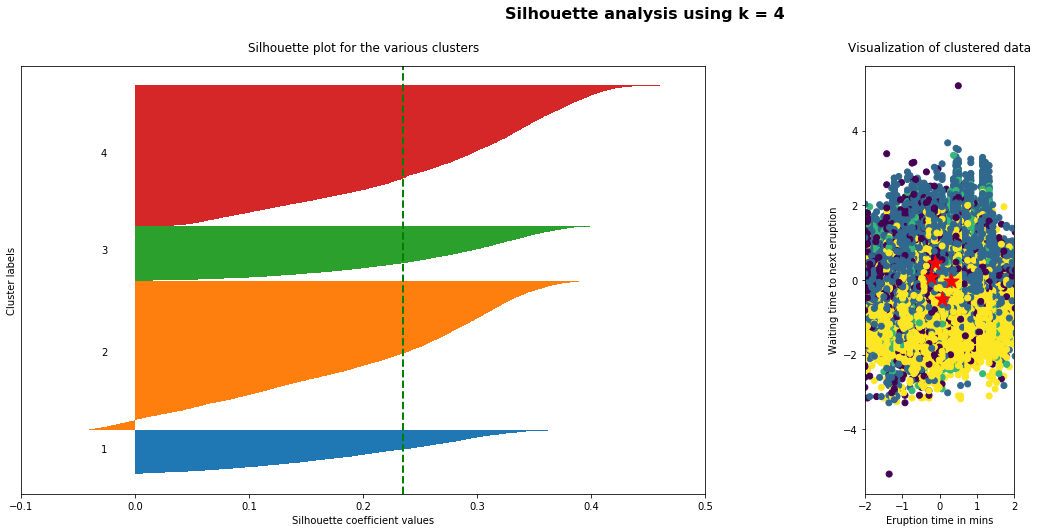

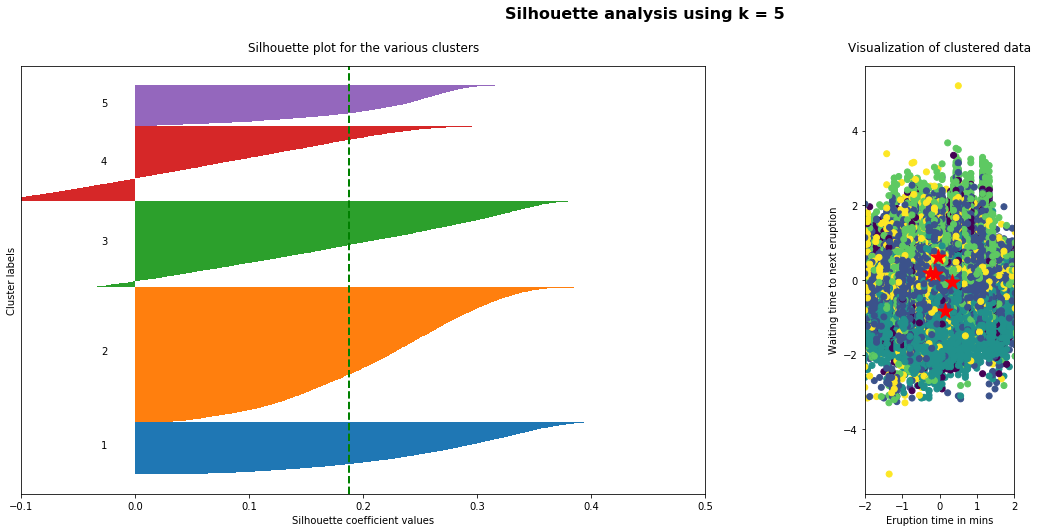

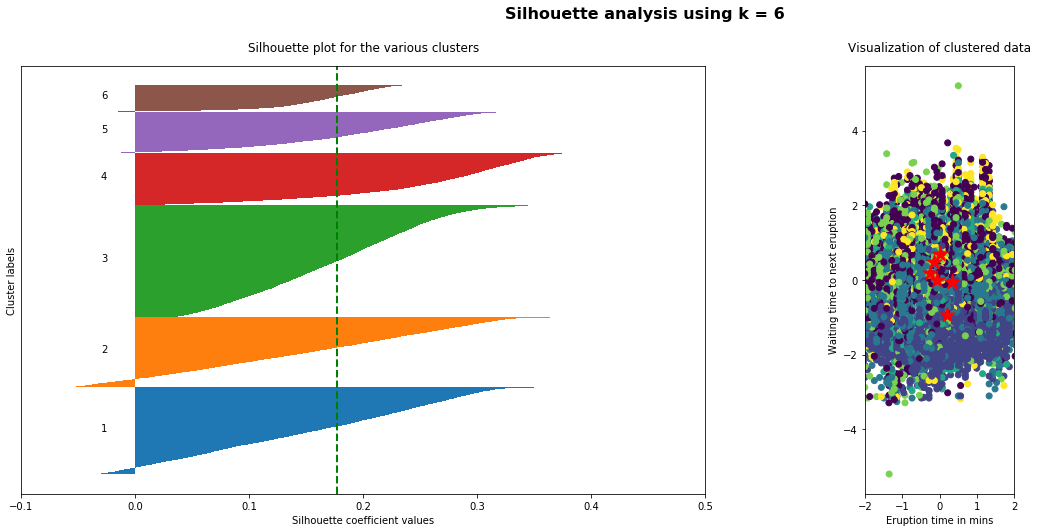

In [16]:
silhouette_analysis_fx(tract_data_scaled)

In [18]:
# based on the elbow and silhouette methods, the best number of clusters 
# appears to be 2. 
kmeans2 = KMeans(n_clusters=2, init='k-means++')
kmeans2.fit(city_data_scaled)
pred = kmeans2.predict(city_data_scaled)
frame=city_data_scaled.copy()
frame['cluster'] = pred
frame.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/kmeans_city_df.csv')
frame['cluster'].value_counts()

1    237
0    204
Name: cluster, dtype: int64

The following two cells just takes a closer look at this clusterization between the two clusters. I wanted to see how they compared when just looking at a few variables. Thus, the pairplot does a good job at comparing them with scatterplots and with the color corresponding to the classification label. 

In [0]:
cancer = frame.loc[:, ['cluster','Breast cancer deaths','Cardiovascular disease deaths',
                       'Colorectal cancer deaths','Diabetes']]

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


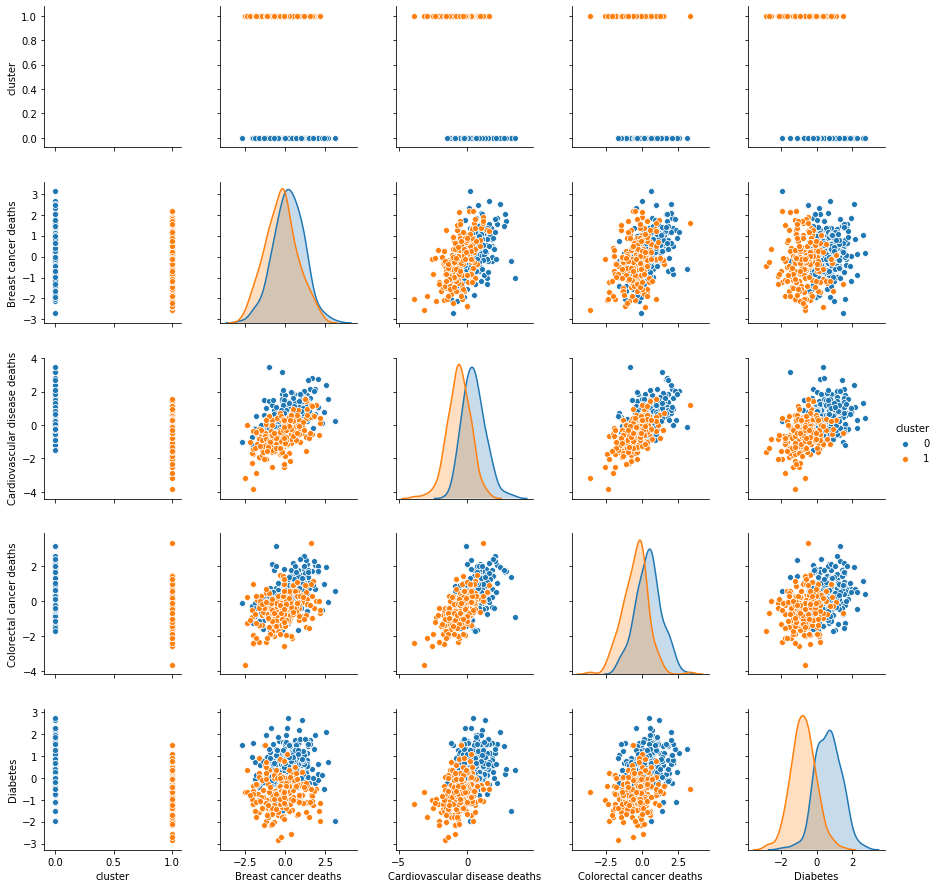

In [0]:
sns.pairplot(cancer, hue='cluster')

100%|██████████| 9/9 [00:14<00:00,  2.07s/it]


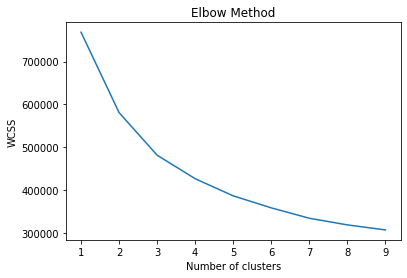

In [0]:
# Elbow method for KMeans
wcss2 = []
for i in tqdm(range(1, 10)):
    kmeans2 = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans2.fit(tract_data_scaled)
    wcss2.append(kmeans2.inertia_)
plt.plot(range(1,10), wcss2)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
# based on the elbow and silhouette methods, the best number of clusters 
# appears to be 4. 
kmeans3 = KMeans(n_clusters=4, init='k-means++')
kmeans3.fit(tract_data_scaled)
pred2 = kmeans3.predict(tract_data_scaled)
frame2=tract_data_scaled.copy()
frame2['cluster'] = pred2
frame2.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/kmeans_tract_df.csv')
frame2['cluster'].value_counts()

2    10327
0     9741
1     3743
3     3037
Name: cluster, dtype: int64

### OPTICS

In [0]:
#converting dataframes into arrays
city_arr = np.array(city_data_scaled)
tract_arr = np.array(tract_data_scaled)

In [0]:
def optics_fx(arr):
    ''' this function uses OPTICS to attempt to cluster the data.
    args:
    - arr - an array of the data (must be an array not a dataframe)
    returns:
    the labels of the clusterization model
  '''
    plt.figure(figsize=(10, 7))
    optics = OPTICS()
    opt_clust = optics.fit(arr)
  # OPTICS
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = arr[opt_clust.labels_ == klass]
        plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.6)
    plt.plot(arr[opt_clust.labels_ == -1, 0], arr[opt_clust.labels_ == -1, 1], 'k+', alpha=0.1)
    plt.title('Automatic Clustering\nOPTICS')
    plt.show()
    return opt_clust.labels_

In [0]:
optic_city = city_data_scaled.copy()
optic_tract = tract_data_scaled.copy()

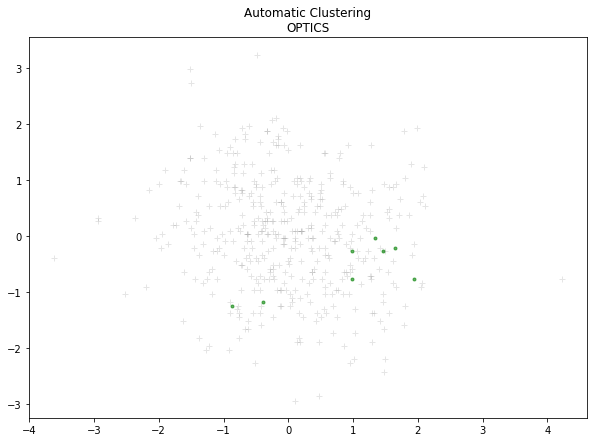

In [33]:
optic_city['optic_cluster'] = optics_fx(city_arr)
optic_city.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/optic_city_df.csv')

most of the datapoints the model classifies as noise, with only a few actually being labeled

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/optics_.py:791: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


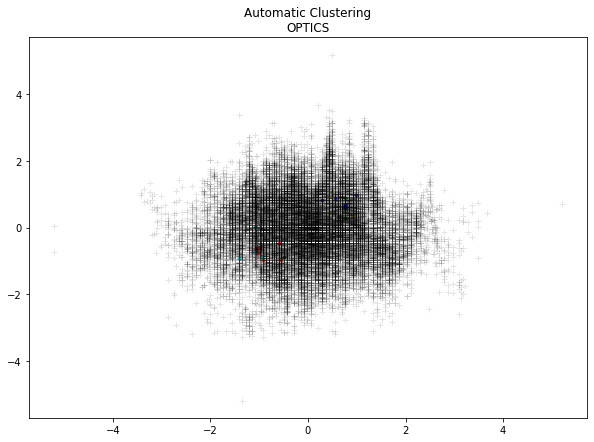

In [34]:
optic_tract['optic_cluster'] = optics_fx(tract_arr)
optic_tract.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/optic_tract_df.csv')

### **HDBSCAN**

In [0]:
def hdbs_fx(arr):
  ''' this function uses HDBSCAN to attempt to cluster the data. cluster size is
  rather small. 
    args:
    - arr - an array of the data (must be an array not a dataframe)
    returns:
    the labels of the clusterization model
  '''
  hdbsc = hdbscan.HDBSCAN(min_cluster_size=4)
  hdbsc.fit_predict(arr)
  pal = sns.color_palette('deep', 170)
  labs = hdbsc.labels_
  colors = [sns.desaturate(pal[col], sat) for col, sat in zip(hdbsc.labels_, hdbsc.probabilities_)]
  plt.scatter(arr.T[0], arr.T[1], c=colors)
  return hdbsc.labels_

In [0]:
hdbs_city = city_data_scaled.copy()
hdbs_tract = tract_data_scaled.copy()

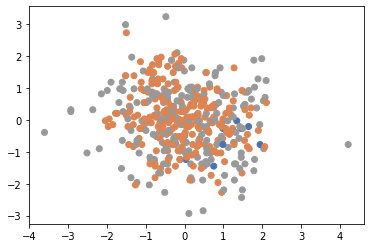

In [35]:
hdbs_city['hdbs_labels'] = hdbs_fx(city_arr)
hdbs_city.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/hdbs_city_df.csv')

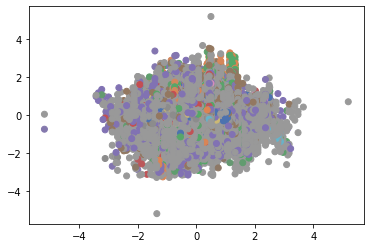

In [36]:
hdbs_tract['hdbs_labels'] = hdbs_fx(tract_arr)
hdbs_tract.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/hdbs_tract_df.csv')

There is a lot of noise in this dataset, the data is basically all on top of one another

### Hierarchical Clustering

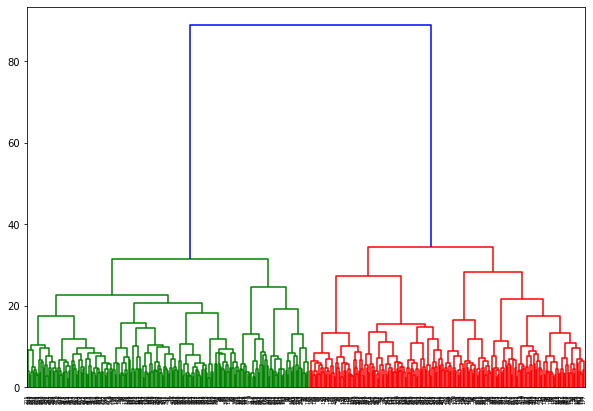

In [0]:
# Takes a while to run, might just want to look at the result that is saved in 
# pics_for_ppt folder rather than run it again. 
# plt.figure(figsize=(10,7))
# dend = shc.dendrogram(shc.linkage(city_data_scaled, method='ward'))

I have counted about 7 clusters

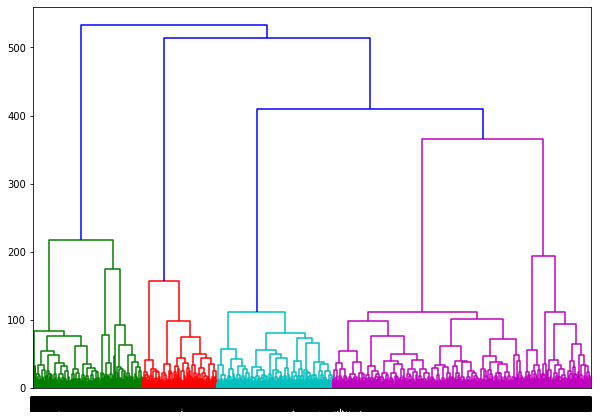

In [0]:
# Takes a while to run, might just want to look at the result that is saved in 
# pics_for_ppt folder rather than run it again. 
# plt.figure(figsize=(10,7))
# dend2 = shc.dendrogram(shc.linkage(tract_data_scaled, method='ward'))

I have counted about 5 clusters

In [0]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean',linkage='ward')
agg_pred = cluster.fit_predict(city_data_scaled)
cds_copy = city_data_scaled.copy()
cds_copy['agg_predicted'] = agg_pred
cds_copy.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/agg_city_df.csv')

In [0]:
cluster_t = AgglomerativeClustering(n_clusters=5, affinity='euclidean',linkage='ward')
agg_pred_t = cluster_t.fit_predict(tract_data_scaled)
tds_copy = tract_data_scaled.copy()
tds_copy['agg_predicted'] = agg_pred_t
tds_copy.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/agg_tract_df.csv')

In [0]:
sequence = list(range(0,42))

In [0]:
rand_cols = sample(sequence, 4)
rand_cols.append(42)
rand_cols

[14, 5, 16, 27, 42]

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


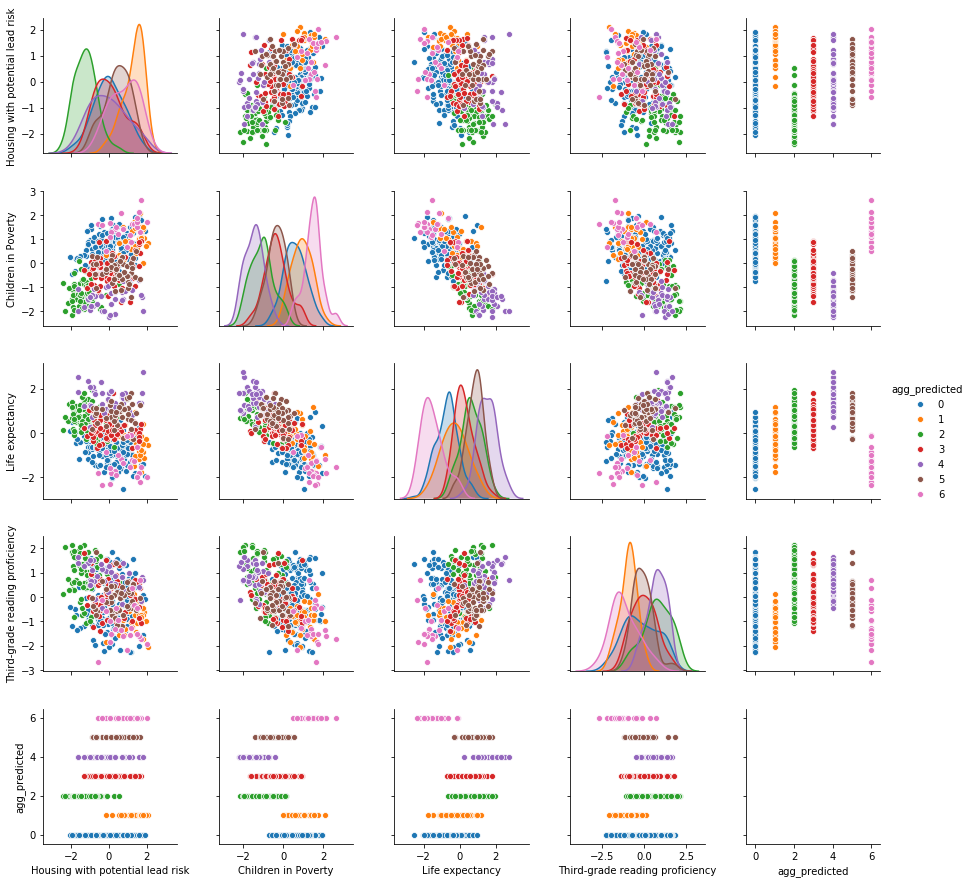

In [0]:
sns.pairplot(cds_copy.iloc[:, rand_cols], hue='agg_predicted')

### AffinityPropagation

In [0]:
affprop = AffinityPropagation()
affpred = affprop.fit_predict(city_data_scaled)
cds_aff = city_data_scaled.copy()
cds_aff['aff_pred']=affpred
cds_aff.to_csv('/content/gdrive/My Drive/Health_Scores_CAP2/manipulated_data/aff_city_df.csv')

In [0]:
# causes the session to crash on google colab and on my computer

# affprop = AffinityPropagation()
# tds_aff = tract_data_scaled.copy()
# affpred_t = affprop.fit_predict(tract_data_scaled)
# tds_aff['aff_pred']=affpred_t

In [0]:
zto3 = list(range(0,4))
zto3.append(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


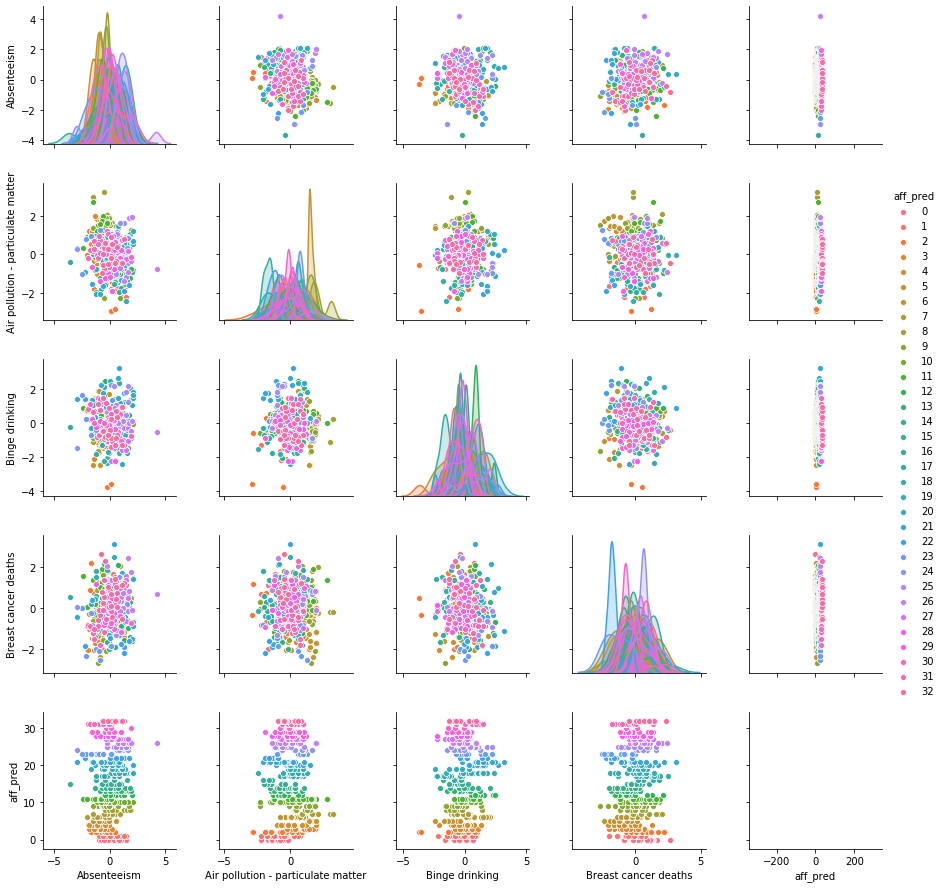

In [0]:
sns.pairplot(cds_aff.iloc[:, zto3],hue='aff_pred')

# Classification

In [0]:
# this is a blank dataframe that will collect all of the scores from each of the models under each classification metric
model_comparison_df = pd.DataFrame()

#### Logistic Regression

In [0]:
# scoring classification models
def cv_score(clf, x, y, score_func=accuracy_score):
  '''This is a custom metric for scoring models. 

  args: 
      clf - classification model
      x - independent variables
      y - response variable
      score_func - type of scoring metric to use on data
  returns: the average score for the model

  '''
    result=0
    nfold=5
    for train, test in KFold(nfold).split(x):
        clf.fit(x[train],y[train])
        result += score_func(clf.predict(x[test]), y[test])
    return result/nfold #average

In [0]:
# using kmeans clustering
warnings.filterwarnings('ignore')
def logreg_fx(data, data_cluster):
  ''' This function goes through the process of creating a DecisionTreeClassifier 
  model, going through a cross validation, parameter tuning, and a stratified 
  KFold cross validation for an average score using accuracy score metric

  args: 
  data - dataframe (city/tract)
  data_clusters - the copy of the dataframe with a column that has the 
  clusterization labels added on the last column the input into this argument 
  should be a pandas series of that column that contains the cluster labels

  returns: average accuracy score
  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  c_space = np.logspace(0.001, 0.1, 1, 10, 100)
  logreg = LogisticRegression()
  param_grid = {'C': c_space}
  logreg_cv = GridSearchCV(logreg, param_grid, cv=5) #parameter tuning
  logreg_cv.fit(X_tr, y_tr)

  print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
  print("Best score is {}".format(logreg_cv.best_score_))
  logreg_best = LogisticRegression(C=logreg_cv.best_params_['C'])
  score = cv_score(logreg_best, X_tr, y_tr)
  return score

In [0]:
logreg_score_c_kmeans = logreg_fx(city_data_scaled, frame['cluster'])
model_comparison_df['logreg_score_c_kmeans'] = logreg_score_c_kmeans
logreg_score_t_kmeans = logreg_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['logreg_score_t_kmeans'] = logreg_score_t_kmeans

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.990909090909091
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.9536650774731824


In [0]:
logreg_score_c_agg = logreg_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['logreg_score_c_agg'] = logreg_score_c_agg
logreg_score_t_agg = logreg_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['logreg_score_t_agg'] = logreg_score_t_agg

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.7909090909090909
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.942938021454112


In [0]:
logreg_score_c_aff = logreg_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['logreg_score_c_aff'] = logreg_score_c_aff
# cannot get Affinity clustering to work on computer for tract data

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.6484848484848484


In [0]:
logreg_score_c_optic = logreg_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['logreg_score_c_optic'] = logreg_score_c_optic

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.990909090909091


In [0]:
logreg_score_t_optic = logreg_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['logreg_score_t_optic'] = logreg_score_t_optic

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.9616110448947159


In [0]:
logreg_score_c_hdbs = logreg_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['logreg_score_c_hdbs'] = logreg_score_c_hdbs

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.6303030303030303


In [0]:
logreg_score_t_hdbs = logreg_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['logreg_score_t_hdbs'] = logreg_score_t_hdbs

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.8911899086213747


#### Decision Tree

In [0]:
def dt_fx(data, data_cluster):
  ''' This function goes through the process of creating a DecisionTreeClassifier 
  model, going through a cross validation, parameter tuning, and a stratified 
  KFold cross validation for an average score using accuracy score metric

            args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: average accuracy score

  '''
    X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                         random_state=5)
    dt = DecisionTreeClassifier()
    dt_base_fit = dt.fit(X_tr, y_tr)
    dt_base_pred = dt_base_fit.predict(X_test)
    dt_base_score = accuracy_score(y_test, dt_base_pred)
    print("Baseline Score: {}".format(dt_base_score))
    
    md = np.linspace(1,32,32,endpoint=True)
    min_samples = np.linspace(0.1,1,10,endpoint=True)
    mleaf = np.linspace(0.1,0.5,5,endpoint=True)
    maxfeat = list(range(1,X_tr.shape[1]))
    param_grid = {'max_depth': md, 'min_samples_split': min_samples, 'min_samples_leaf': mleaf, 
                  'max_features': maxfeat}
    dt_cv = GridSearchCV(dt,param_grid, cv=5, scoring='accuracy')
    dt_cv.fit(X_tr,y_tr)
    print("Tuned Parameters: {}".format(dt_cv.best_params_)) 
    print("Best score is {}".format(dt_cv.best_score_))
    dt_best = DecisionTreeClassifier(max_depth = dt_cv.best_params_['max_depth'],
                                    min_samples_split = dt_cv.best_params_['min_samples_split'],
                                    min_samples_leaf = dt_cv.best_params_['min_samples_leaf'],
                                    max_features = dt_cv.best_params_['max_features'])
    dt_best_fit = dt_best.fit(X_tr, y_tr)
    dt_best_pred = dt_best_fit.predict(X_test)
    dt_score = accuracy_score(y_test, dt_best_pred)
    return dt_score

In [0]:
dt_score_c_kmeans = dt_fx(city_data_scaled, frame['cluster'])
model_comparison_df['dt_score_c_kmeans'] = dt_score_c_kmeans
dt_score_t_kmeans = dt_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['dt_score_t_kmeans'] = dt_score_t_kmeans

Baseline Score: 0.9009009009009009
Tuned Parameters: {'max_depth': 1.0, 'max_features': 13, 'min_samples_leaf': 0.2, 'min_samples_split': 0.30000000000000004}
Best score is 0.9212121212121213
Baseline Score: 0.9524731823599524
Tuned Parameters: {'max_depth': 27.0, 'max_features': 21, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
Best score is 0.8084028605482717


In [0]:
dt_score_c_agg = dt_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['dt_score_c_agg'] = dt_score_c_agg

Baseline Score: 0.7387387387387387
Tuned Parameters: {'max_depth': 12.0, 'max_features': 24, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
Best score is 0.6515151515151515


In [0]:
dt_score_c_aff = dt_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['dt_score_c_aff'] = dt_score_c_aff

Baseline Score: 0.2702702702702703
Tuned Parameters: {'max_depth': 29.0, 'max_features': 14, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
Best score is 0.2515151515151515


In [0]:
dt_score_c_optic = dt_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['dt_score_c_optic'] = dt_score_c_optic

Baseline Score: 0.972972972972973
Tuned Parameters: {'max_depth': 1.0, 'max_features': 1, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
Best score is 0.9818181818181818


In [0]:
dt_score_t_optic = dt_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['dt_score_t_optic'] = dt_score_t_optic

Baseline Score: 0.9371275327771156
Tuned Parameters: {'max_depth': 1.0, 'max_features': 1, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
Best score is 0.9616607071911005


In [0]:
dt_score_c_hdbs = dt_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['dt_score_c_hdbs'] = dt_score_c_hdbs

Baseline Score: 0.6756756756756757
Tuned Parameters: {'max_depth': 29.0, 'max_features': 15, 'min_samples_leaf': 0.1, 'min_samples_split': 0.30000000000000004}
Best score is 0.6696969696969697


In [0]:
dt_score_t_hdbs = dt_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['dt_score_t_hdbs'] = dt_score_t_hdbs

Baseline Score: 0.8577175208581644


#### Random Forest

In [0]:
def rf_fx(data, data_cluster):
  ''' This function goes through the process of creating a RandomForestClassifier 
  model. Model is fit to the training data and an accuracy score is printed. 

            args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: dataframe of feature importances, average accuracy score

  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  mod = RandomForestClassifier()
  mod_base_fit = mod.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  mod_base_score = accuracy_score(y_test, mod_base_pred)
  # print("Baseline Score: {}".format(mod_base_score))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df, mod_base_score

In [0]:
rf_result_c_kmeans = rf_fx(city_data_scaled, frame['cluster'])
model_comparison_df['rf_score_c_kmeans'] = rf_result_c_kmeans[1]
rf_result_c_kmeans[0]

NameError: ignored

In [0]:
rf_result_t_kmeans = rf_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['rf_score_t_kmeans'] = rf_result_t_kmeans[1]
rf_result_t_kmeans[0]

In [0]:
rf_result_c_agg = rf_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['rf_score_c_agg'] = rf_result_c_agg[1]
rf_result_c_agg[0]

In [0]:
rf_result_t_agg = rf_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['rf_score_t_agg'] = rf_result_t_agg[1]
rf_result_t_agg[0]

In [0]:
rf_result_c_aff = rf_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['rf_score_c_aff'] = rf_result_c_aff[1]
rf_result_c_aff[0]

In [0]:
rf_result_c_optic = rf_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['rf_score_c_optic'] = rf_result_c_optic[1]
rf_result_c_optic[0]

In [0]:
rf_result_t_optic = rf_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['rf_score_t_optic'] = rf_result_t_optic[1]
rf_result_t_optic[0]

In [0]:
rf_result_c_hdbs = rf_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['rf_score_c_hdbs'] = rf_result_c_hdbs[1]
rf_result_c_hdbs[0]

In [0]:
rf_result_t_hdbs = rf_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['rf_score_t_hdbs'] = rf_result_t_hdbs[1]
rf_result_t_hdbs[0]

#### Light GBM

In [0]:
def gbm_fx(data, data_cluster):
  ''' This function creates a LGBMRanker model, best attempts were made to have 
  an evaluation metric work with this function but to no avail. 

  args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: dataframe of feature importances
  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  evaluation_dict = {}
  gbm = lgb.LGBMRanker()
  q_train = [X_tr.shape[0]]
  mod_base_fit = gbm.fit(X_tr, y_tr, group=q_train, callbacks=[lgb.record_evaluation(evaluation_dict)])
  mod_base_pred = mod_base_fit.predict(X_test)
  

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df

In [0]:
gbm_fx(city_data_scaled, frame['cluster'])

,Feature,importance
16,Life expectancy,88
5,Children in Poverty,71
13,"Housing cost, excessive",66
23,Premature deaths (all causes),65
21,Park access,58
22,Physical inactivity,57
10,Frequent physical distress,56
15,Income Inequality,54
31,Walkability,49
7,Dental care,47


In [0]:
gbm_fx(tract_data_scaled, frame2['cluster'])

Best Score: defaultdict(<class 'dict'>, {})


,Feature,importance
0,Air pollution - particulate matter,0
15,Racial/ethnic diversity,0
27,LERI_9,0
26,LERI_8,0
25,LERI_7,0
24,LERI_6,0
23,LERI_5,0
22,LERI_4,0
21,LERI_3,0
20,LERI_2,0


In [0]:
gbm_fx(city_data_scaled, cds_copy['agg_predicted'])

Best Score: defaultdict(<class 'dict'>, {})


,Feature,importance
8,Diabetes,93
22,Physical inactivity,88
5,Children in Poverty,76
17,Limited access to healthy foods,74
14,Housing with potential lead risk,68
19,Obesity,61
21,Park access,61
4,Cardiovascular disease deaths,55
26,Smoking,51
29,Uninsured,43


In [0]:
gbm_fx(tract_data_scaled, tds_copy['agg_predicted'])

defaultdict(<class 'dict'>, {})


,Feature,importance
11,Limited access to healthy foods,429
2,Children in Poverty,308
0,Air pollution - particulate matter,196
10,Life expectancy,171
17,Unemployment,167
13,Physical inactivity,161
9,Income Inequality,152
3,Dental care,148
16,Smoking,148
12,Obesity,132


In [0]:
# gbm_fx(city_data_scaled, cds_aff['aff_pred'])

In [0]:
def gbm_Class_fx(data, data_cluster):
    ''' This function goes through the process of creating a LGBMClassifier model, 
  going through a cross validation, plotting the importance of each feature, 
  and a stratified KFold cross validation for an average score using accuracy 
  score metric

  args: 
  data - dataframe (city/tract)
  data_clusters - the copy of the dataframe with a column that has the clusterization 
  labels added on the last column the input into this argument should be a pandas 
  series of that column that contains the cluster labels

  returns: dataframe of feature importances, average accuracy score, standard 
  deviation of accuracy score

  '''
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  gbm = lgb.LGBMClassifier()
  q_train = [X_tr.shape[0]]
  mod_base_fit = gbm.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  score = accuracy_score(y_test, mod_base_pred)
  print("Score: {}".format(score))
  print("Classes: {}".format(mod_base_fit.classes_))
  kfold = StratifiedKFold(n_splits=5, random_state=7)
  results = cross_val_score(gbm, data.values, data_cluster.values, cv=kfold)
  print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df, results.mean()*100, results.std()*100

In [0]:
gbm_result_c_kmeans = gbm_Class_fx(city_data_scaled, frame['cluster'])
model_comparison_df['gbm_score_c_kmeans'] = gbm_result_c_kmeans[1]
model_comparison_df['gbm_scorestd_c_kmeans'] = gbm_result_c_kmeans[2]
gbm_result_c_kmeans[0]

Score: 0.8828828828828829
Classes: [0 1 2 3 4]
Accuracy: 85.07% (4.70%)


,Feature,importance
5,Children in Poverty,325
10,Frequent physical distress,316
16,Life expectancy,309
17,Limited access to healthy foods,284
23,Premature deaths (all causes),254
26,Smoking,243
22,Physical inactivity,235
13,"Housing cost, excessive",232
20,Opioid overdose deaths,231
21,Park access,226


In [0]:
gbm_result_t_kmeans = gbm_Class_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['gbm_score_t_kmeans'] = gbm_result_t_kmeans[1]
model_comparison_df['gbm_scorestd_t_kmeans'] = gbm_result_t_kmeans[2]
gbm_result_t_kmeans[0]

Score: 0.9678188319427891
Classes: [0 1 2 3 4]
Accuracy: 96.66% (0.47%)


,Feature,importance
2,Children in Poverty,1615
13,Physical inactivity,1000
14,Preventive services,981
10,Life expectancy,943
11,Limited access to healthy foods,941
17,Unemployment,926
4,Diabetes,897
18,Uninsured,843
9,Income Inequality,829
5,Frequent mental distress,823


In [0]:
gbm_result_c_agg = gbm_Class_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['gbm_score_c_agg'] = gbm_result_c_agg[1]
model_comparison_df['gbm_scorestd_c_agg'] = gbm_result_c_agg[2]
gbm_result_c_agg[0]

Score: 0.8648648648648649
Classes: [0 1 2 3 4 5 6]
Accuracy: 81.60% (5.57%)


,Feature,importance
15,Income Inequality,514
14,Housing with potential lead risk,485
17,Limited access to healthy foods,398
8,Diabetes,398
10,Frequent physical distress,351
19,Obesity,351
26,Smoking,342
13,"Housing cost, excessive",333
22,Physical inactivity,332
5,Children in Poverty,321


In [0]:
gbm_result_t_agg = gbm_Class_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['gbm_score_t_agg'] = gbm_result_t_agg[1]
model_comparison_df['gbm_scorestd_t_agg'] = gbm_result_t_agg[2]
gbm_result_t_agg[0]

Score: 0.9612634088200238
Classes: [0 1 2 3 4]
Accuracy: 94.82% (0.58%)


,Feature,importance
17,Unemployment,1331
11,Limited access to healthy foods,1298
3,Dental care,1112
13,Physical inactivity,1051
5,Frequent mental distress,1035
9,Income Inequality,1009
2,Children in Poverty,1005
18,Uninsured,788
10,Life expectancy,767
16,Smoking,713


In [0]:
gbm_result_c_aff = gbm_Class_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['gbm_score_c_aff'] = gbm_result_c_aff[1]
model_comparison_df['gbm_scorestd_c_aff'] = gbm_result_c_aff[2]
gbm_result_c_aff[0]

Score: 0.5225225225225225
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Accuracy: 56.49% (3.70%)


,Feature,importance
27,Third-grade reading proficiency,1862
29,Uninsured,1687
17,Limited access to healthy foods,1607
1,Air pollution - particulate matter,1566
5,Children in Poverty,1556
25,Racial/ethnic diversity,1499
12,High school graduation,1490
21,Park access,1488
14,Housing with potential lead risk,1485
13,"Housing cost, excessive",1376


In [0]:
gbm_result_c_optic = gbm_Class_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['gbm_score_c_optic'] = gbm_result_c_optic[1]
model_comparison_df['gbm_scorestd_c_optic'] = gbm_result_c_optic[2]
gbm_result_c_optic[0]

In [0]:
gbm_result_t_optic = gbm_Class_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['gbm_score_t_optic'] = gbm_result_t_optic[1]
model_comparison_df['gbm_scorestd_t_optic'] = gbm_result_t_optic[2]
gbm_result_t_optic[0]

In [0]:
gbm_result_c_hdbs = gbm_Class_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['gbm_score_c_hdbs'] = gbm_result_c_hdbs[1]
model_comparison_df['gbm_scorestd_c_hdbs'] = gbm_result_c_hdbs[2]
gbm_result_c_hdbs[0]

In [0]:
gbm_result_t_hdbs = gbm_Class_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['gbm_score_t_hdbs'] = gbm_result_t_hdbs[1]
model_comparison_df['gbm_scorestd_t_hdbs'] = gbm_result_t_hdbs[2]
gbm_result_t_hdbs[0]

#### XGBoost

In [0]:
def xgm_fx(data, data_cluster):
  ''' This function goes through the process of creating a XGBClassifier model, 
  going through a cross validation, plotting the importance of each feature, 
  and a stratified KFold cross validation for an average score using accuracy score metric

  args: 
  data - dataframe (city/tract)
  data_clusters - the copy of the dataframe with a column that has the clusterization 
  labels added on the last column the input into this argument should be a pandas 
  series of that column that contains the cluster labels

  returns: dataframe of feature importances, average accuracy score, standard 
  deviation of accuracy score

  '''
  data_dmatrix = xgb.DMatrix(data=data,label=data_cluster)
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  xgm = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
  
  mod_base_fit = xgm.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  score = accuracy_score(y_test, mod_base_pred)
  print("Score: {}".format(score))
  print("Classes: {}".format(mod_base_fit.classes_))

  params = {'binary':'logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

  cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="error", 
                    as_pandas=True, seed=42)
  print(cv_results)

  xgb.plot_importance(mod_base_fit)
  plt.rcParams['figure.figsize'] = [5, 5]
  plt.show()

  kfold = StratifiedKFold(n_splits=5, random_state=7)
  results = cross_val_score(xgm, data.values, data_cluster.values, cv=kfold)
  print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df, results.mean()*100, results.std()*100

Score: 0.8648648648648649
Classes: [0 1 2 3 4]
   train-error-mean  train-error-std  test-error-mean  test-error-std
0         -1.068027         0.074727        -0.843538        0.191042
1         -1.150793         0.076679        -1.036281        0.178462
2         -1.142857         0.066363        -1.083900        0.144876


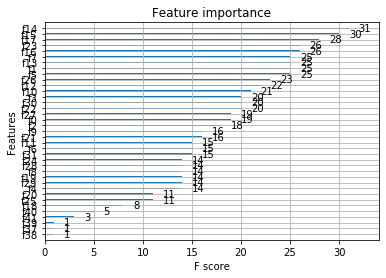

Accuracy: 84.14% (6.27%)


,Feature,importance
16,Life expectancy,0.073448
10,Frequent physical distress,0.067506
41,LERI_10,0.065635
5,Children in Poverty,0.063422
8,Diabetes,0.052670
22,Physical inactivity,0.051816
21,Park access,0.045353
15,Income Inequality,0.041270
23,Premature deaths (all causes),0.040805
31,Walkability,0.036125


In [0]:
xgm_result_c_kmeans = xgm_fx(city_data_scaled, frame['cluster'])
model_comparison_df['xgm_score_c_kmeans'] = xgm_result_c_kmeans[1]
model_comparison_df['xgm_scorestd_c_kmeans'] = xgm_result_c_kmeans[2]
xgm_result_c_kmeans[0]

Score: 0.8265792610250298
Classes: [0 1 2 3 4]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0          -1.258232         0.010521        -1.243966        0.009976
1          -1.261211         0.009343        -1.254432        0.010826
2          -1.265122         0.005830        -1.259162        0.018576
3          -1.265178         0.009872        -1.260578        0.014245
4          -1.276240         0.005195        -1.274322        0.025815
5          -1.291139         0.004791        -1.288401        0.016843
6          -1.291884         0.004629        -1.287806        0.016910
7          -1.294231         0.007495        -1.292461        0.015223
8          -1.297732         0.005932        -1.295776        0.015456
9          -1.300451         0.005953        -1.297750        0.015308
10         -1.301456         0.006405        -1.298644        0.015245
11         -1.297695         0.007985        -1.295106        0.012952
12         -1.298886         0

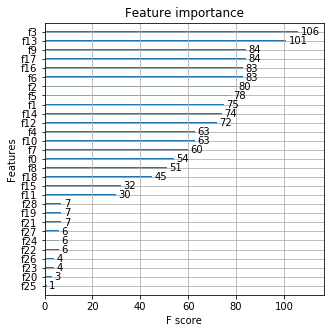

Accuracy: 81.71% (2.30%)


,Feature,importance
11,Limited access to healthy foods,0.425240
3,Dental care,0.088346
5,Frequent mental distress,0.076290
13,Physical inactivity,0.073476
12,Obesity,0.042103
9,Income Inequality,0.030120
4,Diabetes,0.029540
2,Children in Poverty,0.026854
16,Smoking,0.025008
8,Housing with potential lead risk,0.023085


In [0]:
xgm_result_t_kmeans = xgm_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['xgm_score_t_kmeans'] = xgm_result_t_kmeans[1]
model_comparison_df['xgm_scorestd_t_kmeans'] = xgm_result_t_kmeans[2]
xgm_result_t_kmeans[0]

Score: 0.8108108108108109
Classes: [0 1 2 3 4 5 6]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0          -1.180272         0.024684        -0.784580        0.239183
1          -1.252835         0.023620        -0.995465        0.108607
2          -1.244898         0.042027        -1.058957        0.051609
3          -1.162132         0.050932        -0.979592        0.047457
4          -1.181406         0.018491        -1.002268        0.023125
5          -1.210884         0.019440        -1.018141        0.023125
6          -1.218821         0.024264        -1.009070        0.012827
7          -1.231292         0.005554        -1.034014        0.060080
8          -1.226757         0.004242        -1.029478        0.047889
9          -1.229025         0.003206        -1.058957        0.069891
10         -1.235828         0.008484        -1.072562        0.057006
11         -1.239229         0.011224        -1.070294        0.050399
12         -1.244898      

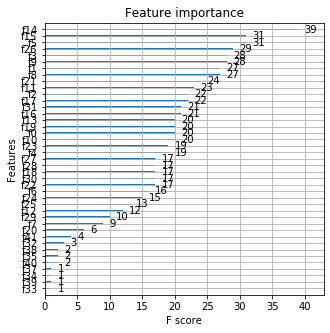

Accuracy: 79.99% (5.45%)


,Feature,importance
32,LERI_1,0.118147
22,Physical inactivity,0.068445
10,Frequent physical distress,0.056145
9,Frequent mental distress,0.044369
17,Limited access to healthy foods,0.041644
14,Housing with potential lead risk,0.040571
8,Diabetes,0.039435
26,Smoking,0.038723
15,Income Inequality,0.036302
5,Children in Poverty,0.035382


In [0]:
xgm_result_c_agg = xgm_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['xgm_score_c_agg'] = xgm_result_c_agg[1]
model_comparison_df['xgm_scorestd_c_agg'] = xgm_result_c_agg[2]
xgm_result_c_agg[0]

Score: 0.8139153754469607
Classes: [0 1 2 3 4]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0          -0.689455         0.002460        -0.676624        0.005277
1          -0.713331         0.006915        -0.705267        0.007146
2          -0.719104         0.005474        -0.711897        0.007141
3          -0.718098         0.005809        -0.711562        0.007581
4          -0.753873         0.040897        -0.746985        0.049364
5          -0.813860         0.001660        -0.809521        0.009687
6          -0.809073         0.001149        -0.805088        0.009410
7          -0.832799         0.017878        -0.828071        0.028283
8          -0.840156         0.005728        -0.836636        0.008867
9          -0.847084         0.014819        -0.840733        0.006419
10         -0.843564         0.016485        -0.838684        0.008231
11         -0.843508         0.015656        -0.837827        0.009353
12         -0.846898         0

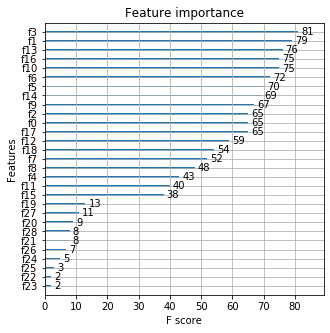

Accuracy: 80.80% (2.51%)


,Feature,importance
11,Limited access to healthy foods,0.422244
2,Children in Poverty,0.083971
5,Frequent mental distress,0.083314
9,Income Inequality,0.059391
3,Dental care,0.057870
14,Preventive services,0.041822
16,Smoking,0.022758
7,"Housing cost, excessive",0.021348
13,Physical inactivity,0.020782
12,Obesity,0.019984


In [0]:
xgm_result_t_agg = xgm_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['xgm_score_t_agg'] = xgm_result_t_agg[1]
model_comparison_df['xgm_scorestd_t_agg'] = xgm_result_t_agg[2]
xgm_result_t_agg[0]

Score: 0.40540540540540543
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
   train-error-mean  train-error-std  test-error-mean  test-error-std
0        -14.232426         0.434606       -12.961451        0.376567
1        -14.304989         0.475780       -14.306123        0.951523
2        -14.308390         0.473921       -14.312925        0.955599


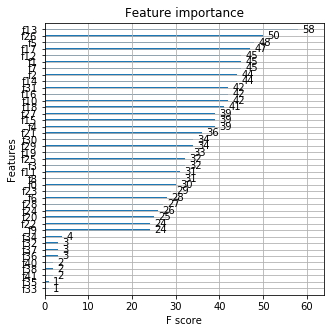

Accuracy: 51.48% (4.99%)


,Feature,importance
32,LERI_1,0.083381
41,LERI_10,0.064414
34,LERI_3,0.038935
33,LERI_2,0.037999
13,"Housing cost, excessive",0.031022
19,Obesity,0.031005
16,Life expectancy,0.030436
20,Opioid overdose deaths,0.029788
7,Dental care,0.029694
26,Smoking,0.028442


In [0]:
xgm_result_c_aff = xgm_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['xgm_score_c_aff'] = xgm_result_c_aff[1]
model_comparison_df['xgm_scorestd_c_aff'] = xgm_result_c_aff[2]
xgm_result_c_aff[0]

In [0]:
xgm_result_c_optic = xgm_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['xgm_score_c_optic'] = xgm_result_c_optic[1]
model_comparison_df['xgm_scorestd_c_optic'] = xgm_result_c_optic[2]
xgm_result_c_optic[0]

In [0]:
xgm_result_t_optic = xgm_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['xgm_score_t_optic'] = xgm_result_t_optic[1]
model_comparison_df['xgm_scorestd_t_optic'] = xgm_result_t_optic[2]
xgm_result_t_optic[0]

In [0]:
xgm_result_c_hdbs = xgm_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['xgm_score_c_hdbs'] = xgm_result_c_hdbs[1]
model_comparison_df['xgm_scorestd_c_hdbs'] = xgm_result_c_hdbs[2]
xgm_result_c_hdbs[0]

In [0]:
xgm_result_t_hdbs = xgm_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['xgm_score_t_hdbs'] = xgm_result_t_hdbs[1]
model_comparison_df['xgm_scorestd_t_hdbs'] = xgm_result_t_hdbs[2]
xgm_result_t_hdbs[0]

#### Comparison of all models run with scores from each model and each classification method

In [0]:
model_comparison_df

The best model is the _______ with the ________ classification method

#### Ranking 

In [0]:
cc = list(city_data_scaled.columns)
tc = list(tract_data_scaled.columns)

In [0]:
# lists to sort columns for use in the upcoming function
ascending_false = ['Dental care','High school graduation','Income Inequality',
                   'Life expectancy','Park access','Preventive services',
                   'Racial/ethnic diversity','Third-grade reading proficiency',
                   'Walkability'] # good to be positive
ascending_true = ['Absenteeism','Air pollution - particulate matter',
                  'Binge drinking','Breast cancer deaths',
                  'Cardiovascular disease deaths', 'Children in Poverty',
                  'Colorectal cancer deaths','Diabetes',
                  'Frequent mental distress','Frequent physical distress', 
                  'High blood pressure', 'Housing cost, excessive',
                  'Housing with potential lead risk','Limited access to healthy foods',
                  'Neighborhood racial/ethnic segregation',
                  'Obesity','Opioid overdose deaths','Physical inactivity',
                  'Premature deaths (all causes)','Smoking','Unemployment',
                  'Uninsured','Violent crime','Lead exposure risk index']# good to be negative

In [0]:
# places features into a list that is only for tract data
a_false_tract = []
a_true_tract = []
for feat in tc:
  if feat in ascending_false:
    a_false_tract.append(feat)
  if feat in ascending_true:
    a_true_tract.append(feat)

In [0]:
def sorting_ranking_fx(df,a_false, a_true):
    '''this function sorts each column in ascending or decending order depending 
    on whether positive or negative values indicate better health.  

    args:
    df - city or tract dataframe
    a_false - a list of column names that are an indicator of good health 
    must only include the columns that are possible for the city/tract
    a_true - a list of column names that are an indicator of poor health must 
    only include the columns that are possible for the city/tract

    returns: dataframe of ranks for each location
  '''
  new_df = df.copy()
  for col in df.columns:
    if col in a_false:
      new_df = new_df.sort_values(col, ascending=False)
    if col in a_true:
      new_df = new_df.sort_values(col)
    new_df[col+'_rank'] = range(1, len(df[col])+1)
  names = list(new_df.columns)
  ranks = []
  for n in names:
    ranks.append(n.endswith('_rank'))
  just_ranks = new_df.loc[:, ranks]
  return just_ranks

In [0]:
# no LERI
city_no_leri = city_data_scaled.iloc[:, :-10]
city_reg_leri = city_no_leri.merge(leri_city, how='outer',left_index=True, right_index=True)
tract_no_leri = tract_data_scaled.iloc[:, :-10]
tract_reg_leri = tract_no_leri.merge(leri_tract, how='outer',left_index=True, right_index=True)

In [0]:
city_ranked = sorting_ranking_fx(city_reg_leri, ascending_false, ascending_true)
tract_ranked = sorting_ranking_fx(tract_reg_leri, a_false_tract, a_true_tract)

##### Adding Weights

In [0]:
def feature_weights(df, weights):
  '''this function calculates the overall health score for each city/tract 
  by multiplying the ranked features by their corresponding weights. 

  args:
  df - ranked city or tract dataframe
  weights - calculated relative importance of each feature taken from classification 
  model

  returns: dataframe of scores for each location, sorted in descending order with 
  respect to overall health score.
  '''
  weighted_df = df.copy()
  for col in df.columns:
    weighted_df[col+'_w'] = df[col]*weights[re.sub('\_rank$', '', col)]
  names = list(weighted_df.columns)
  ws = []
  for n in names:
    ws.append(n.endswith('_w'))
  just_weights = weighted_df.loc[:, ws]
  just_weights['Overall Health Score'] = just_weights.sum(axis=1)
  just_weights = just_weights.sort_values('Overall Health Score', ascending=False)
  return(just_weights)

In [0]:
feature_weights(city_ranked, city_weights)

In [0]:
feature_weights(tract_ranked, tract_weights)